# Faraday Dreams Tutorial

Below you can find a tutorial that shows simulation of measurements from a ground truth Faraday depth signal. Then recovery is performed using Optimus Primal. The tutorial shows the impact of channel averaging depolarization at low frequencies, and how it can be recovered.

In [1]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.plot_spectrum as plot_spectrum
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt

This next bit of code sets up the parameters for the observation. The samples in frequency $\nu$, which determine the samples in $\lambda^2$. The big issue here is channgel width $\Delta \nu$ in frequency is constant, but $\Delta \lambda^2$ is not.

In [86]:
c = 2.92 * 10**8 #speed of light m/s
m_size = 200 #numbr of channels
ISNR = 20. #signal to noise ratio of input noise
freq0 =  np.linspace(400, 800, m_size) * 10**6 # frequency coverage
dfreq = np.abs(freq0[1] - freq0[0]) # channel width
lambda2 = (c/freq0)**2 #wavelength^2 coverage
lambda1 = np.sqrt(lambda2) # wavelength coverage
dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 #channel width in wavelength squared.
phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
phi = np.arange(-1e4, 1e4, dphi) # range in rad/m^2 to do reconstruction of signal
weights = np.ones(m_size) #choosing flat noise
rm_max = np.min([500, phi_max]) #only for plotting

2020-05-24 11:10:04,792 - Faraday Dreams - INFO - φ resolution 1.8765246762994936 rad/m^2.
2020-05-24 11:10:04,793 - Faraday Dreams - INFO - φ max range is 1493.7089274520395 rad/m^2.
2020-05-24 11:10:04,794 - Faraday Dreams - INFO - φ min range is 186.7118478561819 rad/m^2.


### Constructing the model
Below we construct a ground truth Faraday Depth, this can be delta functions, box functions, or gaussian functions.

In [87]:
x_true = np.zeros(phi.shape) * 0j #zero model of signal

In [88]:
# amplitudes = [1, 2, 4] jy, locations = [-40, 25, 0], polarization angles = [0, np.pi/5, -np.pi/3] radians
x_true += models.deltas(phi, [5],[100], [ -np.pi/3]) 

In [89]:
# amplitude = 1 jy, width = 10 rad/m^2, location = 50 rad/m^2, polarization angle = 0 radians
x_true += models.box(phi, 1, 50, 200, 0)

In [90]:
# amplitude = 1 jy, width = 10 rad/m^2, location = 50 rad/m^2, polarization angle = 0 radians
#x_true += models.gaussian(phi, 1, 10, 50, 0)

### Constructing the measurement matrix
The measurement process can be written in the measurement equation
$$P(\lambda^2) = \int P(\phi) a(\lambda^2, \phi) {\rm e}^{2 i \lambda^2 \phi}\Delta \phi \, ,$$
which maps Faraday Depth $\phi$ to the measured wavelength $\lambda^2$ for $P = Q +iU$.
The measurement matrix is determined by the following sum: 
$$P(\lambda^2_p) = \sum_{k=0}^N P(\phi_k) a(\lambda^2_p, \phi_k) {\rm e}^{2 i \lambda^2_p \phi_k}\Delta \phi_k$$
where $P$ is the complex polarization signal. $a$ is the impact of channel averaging (it has a constant value of 1 when there is no averaging). It is a Fourier series between $\lambda^2$ and $\phi$.

We can write this as $$\mathbf{y} = \mathbf{\mathsf{\Phi}}\mathbf{x}$$ since it is a system of linear equations.

In [91]:
# measurement operator with channel averaging
m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights, dlambda2)
m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, lambda2* 0 + 1)
#switch to see how important channel averaging is
m_op = m_op_right

Below we also create a version (for comparing no channel averaging) where $a(\lambda^2_p, \phi_k) = 1$

In [92]:
# measurement operator without channel averaging
lambda2_high_res = np.linspace(np.min(lambda2), np.max(lambda2), 1024)
lambda1_high_res = np.sqrt(lambda2_high_res)
m_op_no_averaging = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)

We calculate our simulated measurements $y$ with added noise.

In [93]:
# simulate measurement process
y0 = m_op_right.dir_op(x_true) 

In [94]:
# add iid noise to measurements
sigma = 10**(-ISNR/20.)  * np.linalg.norm(y0) * 1./ np.sqrt(m_size)
y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size)) * weights

Below we plot our measured signal in $\lambda^2$ (wavelength squared $m^2$) with and without channel averaging (top panel), and compare the absolute value of the measured signal in $\phi$ (Faraday Depth, rad/m$^2$) against the ground truth (bottom panel). 

The missing Fourier coefficients in $\lambda^2$ make the blue curve very different from the original (yellow).

(-500.0, 500.0)

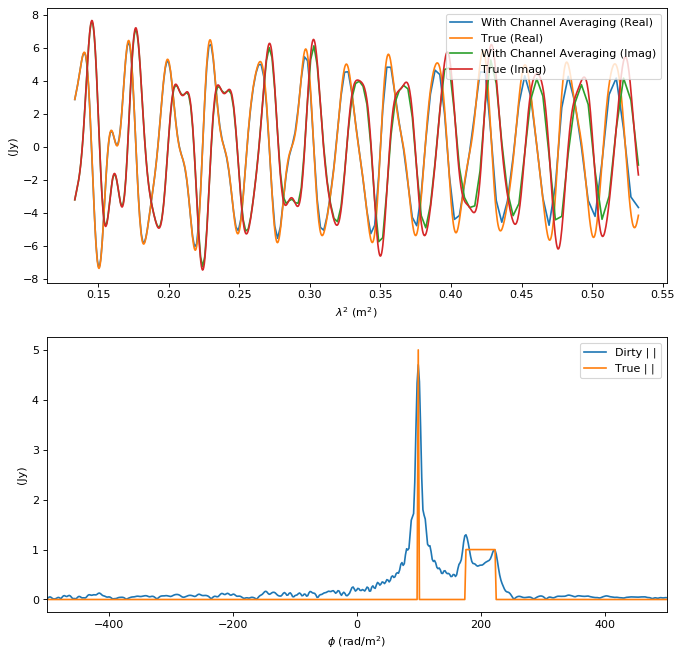

In [95]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=80)
ax[0].plot(lambda2, np.real(y0))
ax[0].plot(lambda2_high_res, np.real(m_op_no_averaging.dir_op(x_true)))
ax[0].plot(lambda2, np.imag(y0))
ax[0].plot(lambda2_high_res, np.imag(m_op_no_averaging.dir_op(x_true)))

ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[0].legend(["With Channel Averaging (Real)", "True (Real)", "With Channel Averaging (Imag)", "True (Imag)"])
ax[1].plot(phi, np.abs(m_op.adj_op(y)) * 1./len(y))
ax[1].plot(phi, np.abs(x_true))
ax[1].legend(["Dirty | |", "True | |", "Solution | |"])
ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[1].set_xlim([-rm_max, rm_max])

You can ignore this next cell for now, but it is needed for the algorithm

Below you can choose assumptions about how to fit the true signal. You can choose wavelets or not (dirac is no wavelets). I suggest no wavelets for now

In [96]:
#choose basis for enforce sparisty (dirac seems to be the best choice, but it depends on wavelength coverage!)
#wav = ["dirac", "db2", "db4", "db6", "db8"]
#wav = ["db8", "dirac"]
wav = ["dirac"]
levels = 6 #wavelet levels, makes no difference for dirac

In [97]:
# you can choose the convergence criteria of the algorithm
options = {'tol': 1e-4, 'iter': 50000, 'update_iter': 1000, 'record_iters': False} #algorithm properties
beta= 1e-3 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad

Here we run the convex optimization algorithm.

We run the solver for our solution signal $\mathbf{z}$ to the minimum of
$$ \|\mathbf{\Psi} \mathbf{x} \|_{\ell_1}\quad {\rm such\, that}\quad \|\mathbf{\Phi} \mathbf{x} - \mathbf{W}\mathbf{y} \|_{\ell_2} \leq \epsilon $$
where $\epsilon = \sigma_{\rm noise}\sqrt{N - 2\sqrt{2N}}$. $\mathbf{\Psi}$ is the wavelet dictionary transform and $\mathbf{\Phi}$ is Fourier Transform. $\|\mathbf{\alpha} \|_{\ell_1} = \sum_k |\alpha_k|$ and $\|\mathbf{\alpha} \|_{\ell_2} = \sqrt{\sum_k |\alpha_k|^2}$.

The basic idea is that $\mathbf{z}$  will not overfit to the signal because it can be efficiently represented with the dictionary.

In [98]:
#get solution of algo and run
nu, sol = linear_operators.power_method(m_op_right, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
solution_right, diag_right = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)

2020-05-24 11:10:18,049 - Optimus Primal - INFO - Starting Power method
2020-05-24 11:10:18,061 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-05-24 11:10:18,091 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-05-24 11:10:18,147 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-05-24 11:10:18,211 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-05-24 11:10:18,260 - Optimus Primal - INFO - [Power Method] iter = 41, tol = 0.0
2020-05-24 11:10:18,288 - Optimus Primal - INFO - [Power Method] Converged with iter = 49, tol = 9.988282767971446e-05
2020-05-24 11:10:18,289 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 6 levels
2020-05-24 11:10:18,290 - Faraday Dreams - INFO - Using an estimated noise level of 0.5172459098090558 (weighted image units, i.e. Jy/Beam)
2020-05-24 11:10:18,293 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-05-24 11:10:18,299 - Optimus Pr

In [99]:
#get solution of algo and run
nu, sol = linear_operators.power_method(m_op_wrong, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
solution_wrong, diag_wrong = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_wrong, wav, levels, nu, beta, options)

2020-05-24 11:10:27,266 - Optimus Primal - INFO - Starting Power method
2020-05-24 11:10:27,285 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-05-24 11:10:27,334 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-05-24 11:10:27,389 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-05-24 11:10:27,459 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-05-24 11:10:27,507 - Optimus Primal - INFO - [Power Method] iter = 41, tol = 0.0
2020-05-24 11:10:27,567 - Optimus Primal - INFO - [Power Method] iter = 51, tol = 0.0
2020-05-24 11:10:27,610 - Optimus Primal - INFO - [Power Method] iter = 61, tol = 0.0
2020-05-24 11:10:27,655 - Optimus Primal - INFO - [Power Method] iter = 71, tol = 0.0
2020-05-24 11:10:27,661 - Optimus Primal - INFO - [Power Method] Converged with iter = 72, tol = 9.687497361127904e-05
2020-05-24 11:10:27,662 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 6 levels
2020-05-24 11:10:27,664 - Faraday

Below we calculate some comparisons to plot against the model. This involes ground truth, measured, and fitted model.

In [100]:
y_right = m_op_right.dir_op(solution_right) 
y_wrong = m_op_wrong.dir_op(solution_wrong) 
y_true = m_op_no_averaging.dir_op(x_true)
y_model_right = m_op_no_averaging.dir_op(solution_right) 
y_model_wrong = m_op_no_averaging.dir_op(solution_wrong) 

(-500.0, 500.0)

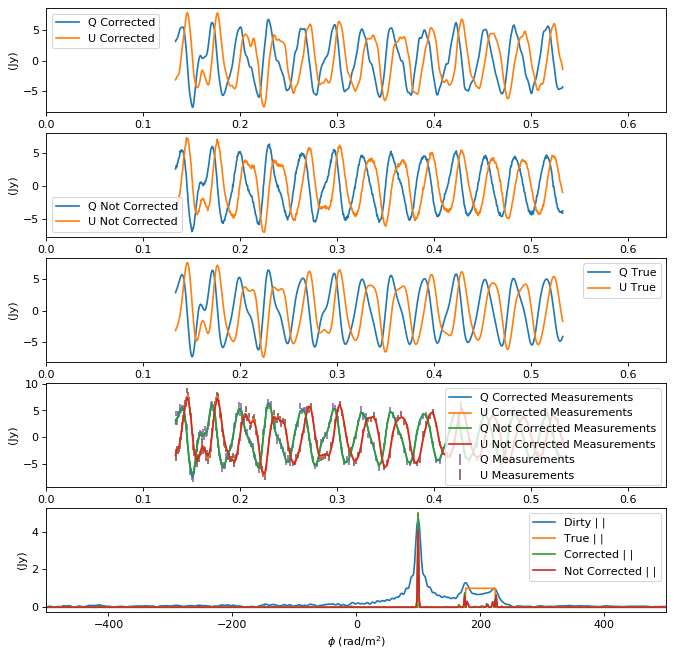

In [101]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), dpi=80)
ax[0].plot(lambda2_high_res, np.real(y_model_right))
ax[0].plot(lambda2_high_res, np.imag(y_model_right))
ax[1].plot(lambda2_high_res, np.real(y_model_wrong))
ax[1].plot(lambda2_high_res, np.imag(y_model_wrong))
ax[2].plot(lambda2_high_res, np.real(m_op_no_averaging.dir_op(x_true)))
ax[2].plot(lambda2_high_res, np.imag(m_op_no_averaging.dir_op(x_true)))
ax[0].set_xlim([0., 0.8**2])
ax[1].set_xlim([0., 0.8**2])
ax[2].set_xlim([0., 0.8**2])
ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[1].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[2].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[2].set_ylabel(r"(Jy)")
ax[0].legend(["Q Corrected", "U Corrected"])
ax[1].legend(["Q Not Corrected", "U Not Corrected"])
ax[2].legend(["Q True", "U True"])
ax[3].plot(lambda2, np.real(y_right))
ax[3].plot(lambda2, np.imag(y_right))
ax[3].plot(lambda2, np.real(y_wrong))
ax[3].plot(lambda2, np.imag(y_wrong))
ax[3].errorbar(lambda2, np.real(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
ax[3].errorbar(lambda2, np.imag(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
ax[3].set_xlim([0., 0.8**2])
ax[3].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[3].set_ylabel(r"(Jy)")
ax[3].legend(["Q Corrected Measurements", "U Corrected Measurements", "Q Not Corrected Measurements", "U Not Corrected Measurements","Q Measurements", "U Measurements",])
ax[4].plot(phi, np.abs(m_op.adj_op(y)) * 1./len(y))
ax[4].plot(phi, np.abs(x_true))
ax[4].plot(phi, np.abs(solution_right))
ax[4].plot(phi, np.abs(solution_wrong))
ax[4].legend(["Dirty | |", "True | |", "Corrected | |", "Not Corrected | |"])
ax[4].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[4].set_ylabel(r"(Jy)")
ax[4].set_xlim([-rm_max, rm_max])